In [19]:
## RHW LIFETIME PREDICTION

from matplotlib import pyplot as plt
import numpy as np
from numpy.linalg import norm

from astropy.coordinates import solar_system_ephemeris
from astropy.time import Time, TimeDelta
from astropy import units as u

from poliastro.bodies import Earth, Moon, Sun
from poliastro.constants import rho0_earth, H0_earth

from poliastro.core.elements import rv2coe
from poliastro.core.perturbations import (J2_perturbation, third_body, atmospheric_drag_exponential)
from poliastro.core.propagation import func_twobody 
from poliastro.ephem import build_ephem_interpolant
from poliastro.plotting import OrbitPlotter2D, OrbitPlotter3D
from poliastro.twobody import Orbit
from poliastro.twobody.propagation import CowellPropagator
from poliastro.twobody.sampling import EpochsArray
from poliastro.util import norm, time_range, Time
from poliastro.twobody.events import AltitudeCrossEvent

# RHW orbit parameters at t_0
a    = 6865.501217185909 * u.km
ecc  = 0.001662800000000315 * u.one
inc  = 97.4864 * u.deg
raan = 39.16399999999999 * u.deg
argp = 0 * u.deg
nu   = 0 * u.deg

epoch_0 = Time("2018-11-03 03:53:03", scale = "utc")

rhw_orb_0 = Orbit.from_classical(
    Earth,
    a,
    ecc,
    inc,
    raan,
    argp,
    nu,
    epoch_0
)

# RHW body parameters
C_D = 2.2
A_over_m = ((0.02 * u.m**2) / (2.205 * u.kg)).to_value(u.km**2 / u.kg)
B = A_over_m * C_D

# Earth and atmosphere parameters

k  = Earth.k.to_value(u.km**3 / u.s**2)
R  = Earth.R.to_value(u.km)
J2 = Earth.J2.value
rho0 = rho0_earth.to_value (u.kg / u.km**3)
H0   = H0_earth.to_value(u.km)


In [20]:
solar_system_ephemeris.set("de432s")
moon_r = build_ephem_interpolant(Moon, 28 * u.day, (epoch_0, epoch_0 + 1900 * u.day))
k_moon = Moon.k.to_value(u.km**3 / u.s**2)

In [21]:
# definition of the pertubating acceleration 
def acc(t0, state, k, J2, R, C_D, A_over_m, rho0, k_moon, moon_r):
    return J2_perturbation(
          t0, 
          state, 
          k, 
          J2, 
          R) + atmospheric_drag_exponential(
            t0, 
            state, 
            k, 
            R,
            C_D, 
            A_over_m,
            H0, 
            rho0) + third_body(
                t0, 
                state, 
                k, 
                k_moon, 
                moon_r )



In [22]:

def f(t0, state, k):
    du_kep = func_twobody(t0, state, k)
    ax, ay, az = acc(t0, 
                     state, 
                     k, 
                     J2 = J2, 
                     R = R, 
                     C_D = C_D, 
                     A_over_m = A_over_m, 
                     rho0 = rho0, 
                     k_moon = k_moon, 
                     moon_r = moon_r)

    du_acc = np.array([0, 0, 0, ax, ay, az])

    return du_kep + du_acc

In [23]:

tofs = TimeDelta(np.linspace(0, 1900 * u.day, num = 3000000))

In [24]:

decay_altitude = 100
decay_event = AltitudeCrossEvent(decay_altitude, R)
events = [decay_event]

In [25]:
rhw_ephem, _ = rhw_orb_0.to_ephem(EpochsArray(rhw_orb_0.epoch + tofs, method = CowellPropagator(rtol = 1e-07, events = events, f=f))).rv()

In [30]:
from numpy.linalg import norm
altitudes = np.apply_along_axis(norm, 1, (rhw_ephem.to_value(u.km))) - Earth.R.to_value(u.km)

Text(0.5, 0, 'Time [days]')

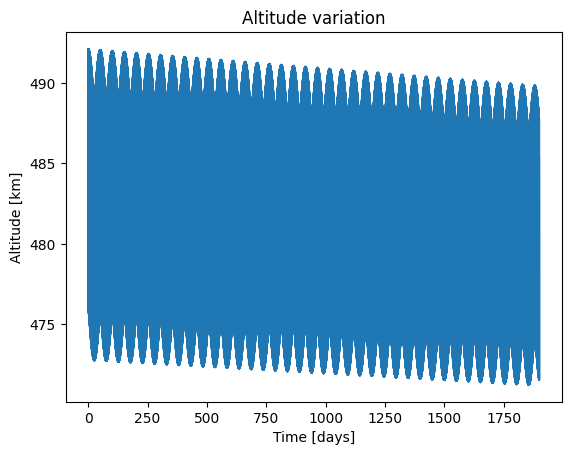

In [31]:
plt.plot(tofs[:len(rhw_ephem)].to_value(u.day), altitudes)
plt.title("Altitude variation")
plt.ylabel("Altitude [km]")
plt.xlabel("Time [days]")

In [33]:
rhw_ephem_orb = rhw_orb_0.to_ephem(EpochsArray(rhw_orb_0.epoch + tofs, method = CowellPropagator(rtol = 1e-07, events = events, f=f)))

In [35]:
rhw_ephem_orb

Ephemerides at 3000000 epochs from 2018-11-03 03:53:03.000 (UTC) to 2024-01-16 03:53:03.000 (UTC)

In [37]:
from poliastro.earth.atmosphere import jacchia


In [39]:
from poliastro.core.perturbations import (atmospheric_drag)

In [40]:
jacchia.Jacchia77

poliastro.earth.atmosphere.jacchia.Jacchia77

In [42]:
jacchia.Jacchia77

poliastro.earth.atmosphere.jacchia.Jacchia77